In [339]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [340]:
df_va=pd.read_csv(r"C:\Users\Ashutosh Gupta\OneDrive\문서\emotion_recognition_research\data\DEAM_Annotations\annotations\annotations averaged per song\song_level\static_annotations_averaged_songs_1_2000.csv")
print(df_va.shape)
print(df_va.columns)
df_va.head()

(1744, 5)
Index(['song_id', ' valence_mean', ' valence_std', ' arousal_mean',
       ' arousal_std'],
      dtype='object')


,song_id,valence_mean,valence_std,arousal_mean,arousal_std
0,2,3.1,0.94,3.0,0.63
1,3,3.5,1.75,3.3,1.62
2,4,5.7,1.42,5.5,1.63
3,5,4.4,2.01,5.3,1.85
4,7,5.8,1.47,6.4,1.69


In [ ]:
AUDIO_DIR = r"C:\Users\Ashutosh Gupta\OneDrive\문서\emotion_recognition_research\data\DEAM_audio\MEMD_audio"

def extract_features(file_path, sr=22050):
    try:
        y, sr = librosa.load(file_path, sr=sr)

        features = []

        # MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        features.extend(np.mean(mfcc, axis=1))
        features.extend(np.std(mfcc, axis=1))

        # STFT for chroma & contrast
        stft = np.abs(librosa.stft(y))

        # Chroma
        chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
        features.extend(np.mean(chroma, axis=1))
        features.extend(np.std(chroma, axis=1))

        # Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        features.extend(np.mean(mel, axis=1))
        features.extend(np.std(mel, axis=1))

        # Spectral Contrast
        contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
        features.extend(np.mean(contrast, axis=1))
        features.extend(np.std(contrast, axis=1))

        # Tonnetz
        y_harm = librosa.effects.harmonic(y)
        tonnetz = librosa.feature.tonnetz(y=y_harm, sr=sr)
        features.extend(np.mean(tonnetz, axis=1))
        features.extend(np.std(tonnetz, axis=1))

        return np.array(features)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


labels_df = df_va[['song_id',' valence_mean', ' arousal_mean']]  # Only keep required columns

# Feature extraction loop
feature_rows = []
feature_ids = []

print("Extracting features...")
for song_id in tqdm(labels_df['song_id']):
    file_path = os.path.join(AUDIO_DIR, f"{song_id}.mp3")  # or .wav
    if os.path.exists(file_path):
        feats = extract_features(file_path)
        if feats is not None:
            feature_rows.append(feats)
            feature_ids.append(song_id)
    else:
        print(f"File not found: {file_path}")

In [ ]:
feature_names = []

# MFCC (40 mean + 40 std)
feature_names += [f'mfcc_{i+1}_mean' for i in range(40)]
feature_names += [f'mfcc_{i+1}_std' for i in range(40)]

# Chroma (12 mean + 12 std)
feature_names += [f'chroma_{i+1}_mean' for i in range(12)]
feature_names += [f'chroma_{i+1}_std' for i in range(12)]

# Mel Spectrogram (128 mean + 128 std)
feature_names += [f'mel_{i+1}_mean' for i in range(128)]
feature_names += [f'mel_{i+1}_std' for i in range(128)]

# Spectral Contrast (7 mean + 7 std)
feature_names += [f'contrast_{i+1}_mean' for i in range(7)]
feature_names += [f'contrast_{i+1}_std' for i in range(7)]

# Tonnetz (6 mean + 6 std)
feature_names += [f'tonnetz_{i+1}_mean' for i in range(6)]
feature_names += [f'tonnetz_{i+1}_std' for i in range(6)]

In [ ]:
feature_array = np.array(feature_rows)
feature_df = pd.DataFrame(feature_array)
feature_df.insert(0, 'song_id', feature_ids)
feature_df.columns = ['song_id'] + feature_names
# Merging
final_df = pd.merge(feature_df, labels_df, on='song_id')
final_df.head()

In [344]:
final_df=pd.read_csv(r"modeling_dataset.csv")
final_df.head()

,song_id,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,tonnetz_5_mean,tonnetz_6_mean,tonnetz_1_std,tonnetz_2_std,tonnetz_3_std,tonnetz_4_std,tonnetz_5_std,tonnetz_6_std,valence_mean,arousal_mean
0,2,-138.777924,115.720337,-13.459589,28.933588,4.248804,12.083774,3.440123,1.103790,-0.378012,...,-0.017396,-0.003699,0.252294,0.127111,0.144292,0.187396,0.094571,0.105025,3.1,3.0
1,3,-245.038177,129.646362,11.065094,44.862827,19.510803,27.888992,20.369873,14.797477,10.218618,...,0.053657,0.007337,0.243557,0.349325,0.322155,0.311657,0.141613,0.165230,3.5,3.3
2,4,-104.940300,113.598953,-11.113584,35.522587,29.523623,11.210073,-0.792314,4.643266,-0.524690,...,0.038402,0.061611,0.127788,0.114630,0.179235,0.126345,0.042162,0.059579,5.7,5.5
3,5,-142.962723,116.626892,4.480031,25.239824,-6.341499,-12.160521,-6.476308,-11.558755,-10.434072,...,-0.009054,0.049743,0.153614,0.119581,0.256555,0.195508,0.085711,0.090262,4.4,5.3
4,7,-150.702347,109.894318,25.223463,47.542030,16.307180,31.043228,7.611819,11.738302,-3.218448,...,-0.011649,-0.048040,0.135526,0.151095,0.214128,0.192780,0.096041,0.074727,5.8,6.4


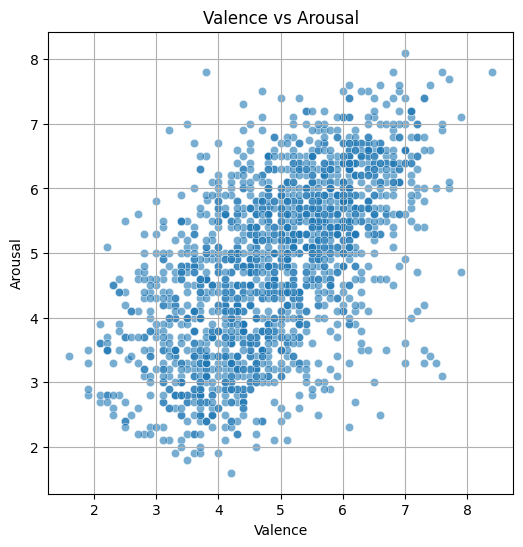

In [371]:
plt.figure(figsize=(6, 6))
sns.scatterplot(
    x=final_df[' valence_mean'],
    y=final_df[' arousal_mean'],
    alpha=0.6
)
plt.title('Valence vs Arousal')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.grid(True)
plt.show()

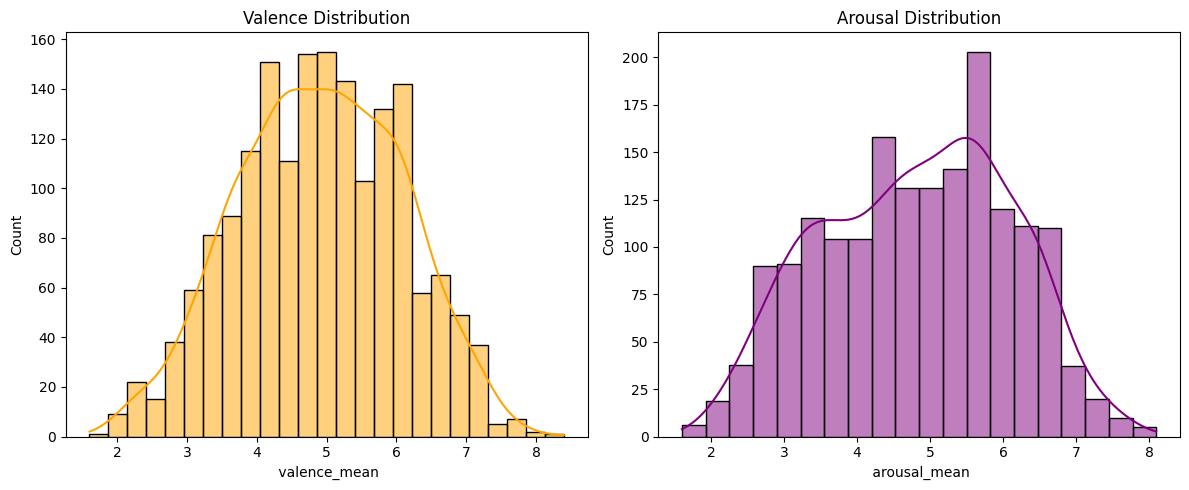

In [345]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(final_df[' valence_mean'], kde=True, color='orange')
plt.title('Valence Distribution')

plt.subplot(1, 2, 2)
sns.histplot(final_df[' arousal_mean'], kde=True, color='purple')
plt.title('Arousal Distribution')
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import pearsonr
feature_cols = [col for col in final_df.columns if col.startswith(('mfcc', 'mel', 'chroma', 'tonnetz', 'contrast'))]

val_corrs = []
for col in feature_cols:
    corr, _ = pearsonr(final_df[col], final_df[' valence_mean'])
    val_corrs.append((col, abs(corr)))

val_corrs = sorted(val_corrs, key=lambda x: x[1], reverse=True)
print('for valence: ')
pearsonr_v=[]
for i, (feat, corr_val) in enumerate(val_corrs[:15]):
    pearsonr_v.append(feat)
    print(f"{i+1}. {feat}: |r| = {corr_val:.4f}")

print('----------x------x-------x---------')
print('for arousal: ')
aro_corrs = []
for col in feature_cols:
    corr, _ = pearsonr(final_df[col], final_df[' arousal_mean'])
    aro_corrs.append((col, abs(corr)))

aro_corrs = sorted(aro_corrs, key=lambda x: x[1], reverse=True)
pearsonr_a=[]
for i, (feat, corr_aro) in enumerate(aro_corrs[:15]):
    pearsonr_a.append(feat)
    print(f"{i+1}. {feat}: |r| = {corr_aro:.4f}")

C:\Users\Ashutosh Gupta\AppData\Local\Temp\ipykernel_11204\3446028766.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


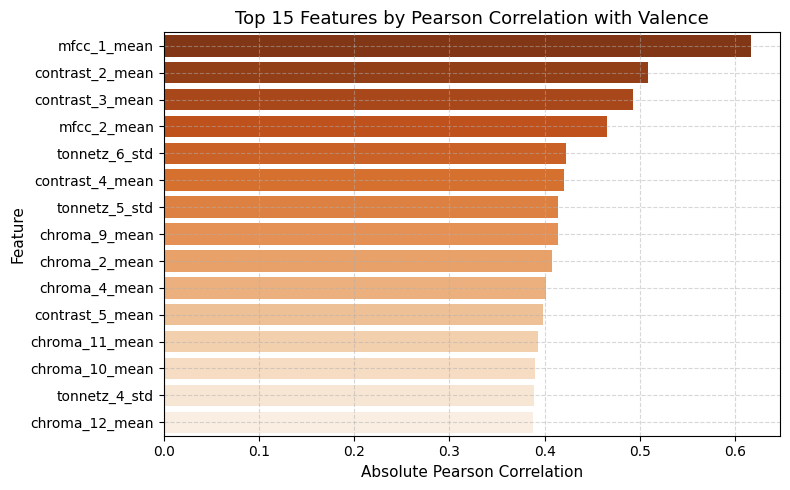

C:\Users\Ashutosh Gupta\AppData\Local\Temp\ipykernel_11204\3446028766.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


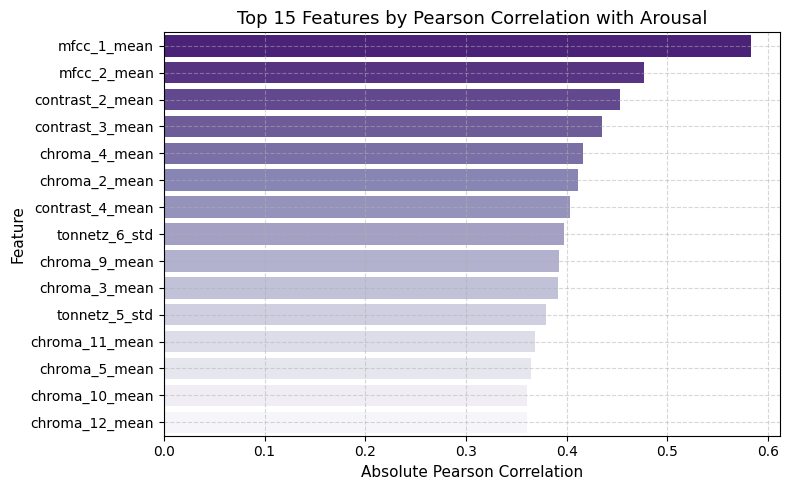

In [372]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Compute Pearson correlations for valence and arousal
cor_valence = final_df.corr()[' valence_mean'].dropna().abs().sort_values(ascending=False)
cor_arousal = final_df.corr()[' arousal_mean'].dropna().abs().sort_values(ascending=False)

# Step 2: Remove self-correlations and select top 15
top15_valence_corr = cor_valence.drop([' valence_mean', ' arousal_mean']).head(15)
top15_arousal_corr = cor_arousal.drop([' valence_mean', ' arousal_mean']).head(15)

# Step 3: Plot top 15 correlations for valence
plt.figure(figsize=(8, 5))
sns.barplot(
    x=top15_valence_corr.values,
    y=top15_valence_corr.index,
    palette='Oranges_r'
)
plt.title('Top 15 Features by Pearson Correlation with Valence', fontsize=13)
plt.xlabel('Absolute Pearson Correlation', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Step 4: Plot top 15 correlations for arousal
plt.figure(figsize=(8, 5))
sns.barplot(
    x=top15_arousal_corr.values,
    y=top15_arousal_corr.index,
    palette='Purples_r'
)
plt.title('Top 15 Features by Pearson Correlation with Arousal', fontsize=13)
plt.xlabel('Absolute Pearson Correlation', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



In [347]:
X = final_df.drop(columns=['song_id', ' valence_mean', ' arousal_mean'])
y_valence = final_df[' valence_mean']
y_arousal = final_df[' arousal_mean']

In [348]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [349]:
y = pd.DataFrame({
    'valence': y_valence,
    'arousal': y_arousal
})

# Split features and both targets at once
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train=pd.DataFrame(X_train,columns=X.columns)
X_test=pd.DataFrame(X_test,columns=X.columns)
# Then access each column separately
y_train_valence = y_train['valence']
y_train_arousal = y_train['arousal']
y_test_valence = y_test['valence']
y_test_arousal = y_test['arousal']
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95, svd_solver='full')
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

<Axes: xlabel=' valence_mean', ylabel='Count'>

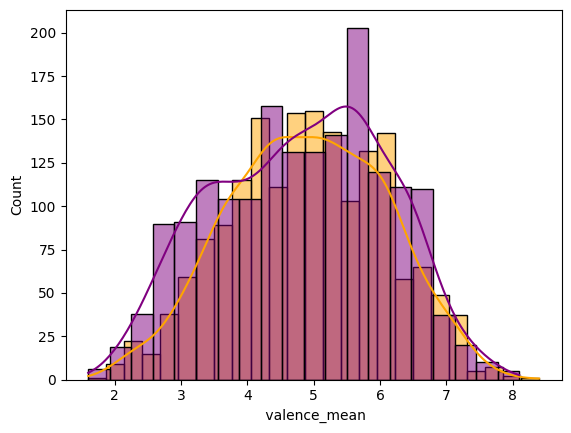

In [366]:
sns.histplot(y_valence, kde=True, color='orange')
sns.histplot(y_arousal, kde=True, color='purple')

In [350]:
models_and_params = {
    'ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.01, 0.1, 1, 10]
        }
    },
    'lasso': {
        'model': Lasso(max_iter=10000),
        'params': {
            'model__alpha': [0.001, 0.01, 0.1, 1]
        }
    },
    'rf': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10, 20]
        }
    },
    'gbr': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    },
    'xgb': {
        'model': XGBRegressor(random_state=42, verbosity=0),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    },
    'svr': {
        'model': SVR(),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__gamma': ['scale', 'auto'],
            'model__kernel': ['rbf', 'linear']
        }
    }
}

In [351]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def run_grid_search(X, y, models_and_params, scoring='r2'):
    best_models = {}

    for name, mp in models_and_params.items():
        print(f"\nRunning GridSearchCV for: {name.upper()}")
        
        pipe = Pipeline([
            ('model', mp['model'])
        ])

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=mp['params'],
            cv=5,
            scoring=scoring,
            n_jobs=-1,
            verbose=0
        )

        grid.fit(X, y)

        print(f"Best {scoring.upper()} Score: {grid.best_score_:.4f}")
        print(f"Best Params: {grid.best_params_}")
        best_models[name] = grid
    return best_models

In [ ]:
best_models = run_grid_search(X_train, y_train_valence, models_and_params, scoring='r2') both work best on xgbregressor
best_models = run_grid_search(X_train, y_train_arousal, models_and_params, scoring='r2')

In [ ]:
X_train_v=X_train.copy()
X_test_v=X_test.copy()

X_train_a=X_train.copy()
X_test_a=X_test.copy()

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(y_true, y_pred, label):
    print(f"\n{label.upper()} Evaluation Metrics:")
    print(f"   R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"   MAE     : {mean_absolute_error(y_true, y_pred):.4f}")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # ← Fix here
    print(f"   RMSE    : {rmse:.4f}")

# Valence Model
best_xgb_v = XGBRegressor(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    random_state=42
)
best_xgb_v.fit(X_train_v, y_train_valence)
y_pred_v = best_xgb_v.predict(X_test_v)
evaluate_model(y_test_valence, y_pred_v, label="valence")

# Arousal Model
best_xgb_a = XGBRegressor(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    random_state=42
)
best_xgb_a.fit(X_train_a, y_train_arousal)
y_pred_a = best_xgb_a.predict(X_test_a)
evaluate_model(y_test_arousal, y_pred_a, label="arousal")



📊 VALENCE Evaluation Metrics:
   R² Score: 0.4667
   MAE     : 0.6827
   RMSE    : 0.8391

📊 AROUSAL Evaluation Metrics:
   R² Score: 0.4114
   MAE     : 0.7818
   RMSE    : 0.9752


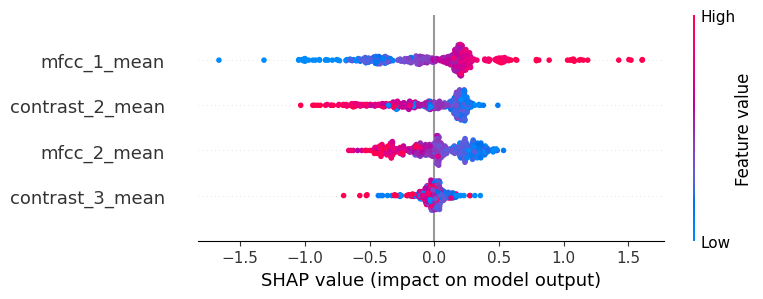

In [355]:
import shap
explainer = shap.Explainer(best_xgb_v, X_train_v)
shap_values = explainer(X_train_v[:500])
shap.summary_plot(shap_values, X_train_v.iloc[:500], max_display=20)

In [356]:
import numpy as np
shap_means = np.abs(shap_values.values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X_train_v.columns,
    'mean_abs_shap': shap_means
}).sort_values(by='mean_abs_shap', ascending=False)

shap_top15_v = shap_importance_df.head(15)['feature'].tolist()
print("🔍 Top 15 SHAP features (valence):")
print(shap_top15_v)

🔍 Top 15 SHAP features (valence):
['mfcc_1_mean', 'contrast_2_mean', 'mfcc_2_mean', 'contrast_3_mean']


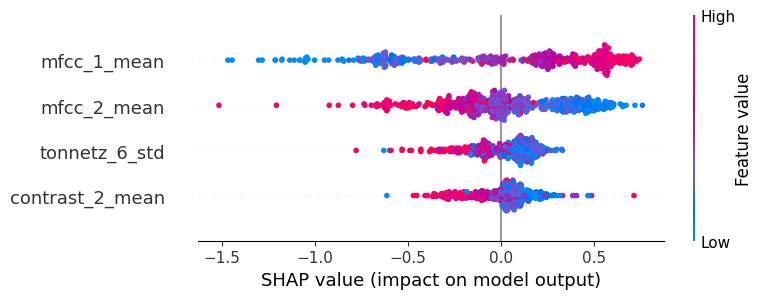

In [357]:
import shap
explainer = shap.Explainer(best_xgb_a, X_train_a)
shap_values = explainer(X_train_a[:500])
shap.summary_plot(shap_values, X_train_a.iloc[:500], max_display=20)

In [358]:
import numpy as np
shap_means = np.abs(shap_values.values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X_train_a.columns,
    'mean_abs_shap': shap_means
}).sort_values(by='mean_abs_shap', ascending=False)

shap_top15_a = shap_importance_df.head(15)['feature'].tolist()
print("🔍 Top 15 SHAP features (arousal):")
print(shap_top15_a)

🔍 Top 15 SHAP features (arousal):
['mfcc_1_mean', 'mfcc_2_mean', 'tonnetz_6_std', 'contrast_2_mean']
